Among a few libraries supporting Bayesian framework including BO (Basyesian Optimization) 
'Pyro' is chosen to be used for this project. 

In [5]:
!pip install -r iTransformer/requirements.txt

In [6]:
%reset -s -f

In [7]:
import logging
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyro
import yfinance as yf

In [8]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.9.1')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [10]:

import yfinance as yf

assets = "BTC-USD"

start_date = "2024-01-01"
end_date = "2025-01-01"

# auto_adjust=True is applied by default
df = yf.download(assets, start=start_date, end=end_date)['Close']
df.columns = ['Close']
df['LogRet'] = np.log(df['Close'] / df['Close'].shift(1))

df['MA_5'] = df['LogRet'].rolling(window=5).mean()
df['MA_10'] = df['LogRet'].rolling(window=10).mean()
df['MA_20'] = df['LogRet'].rolling(window=20).mean()

df.dropna(inplace=True)
df.head()

[*********************100%***********************]  1 of 1 completed


,Close,LogRet,MA_5,MA_10,MA_20
Date,,,,,
2024-01-21,41545.785156,-0.002879,-0.007600,-0.010983,-0.003059
2024-01-22,39507.367188,-0.050309,-0.015742,-0.008129,-0.006462
2024-01-23,39845.550781,0.008524,-0.006987,-0.007252,-0.003633
2024-01-24,40077.074219,0.005794,-0.007548,-0.004200,-0.004873
2024-01-25,39933.808594,-0.003581,-0.008490,-0.006256,-0.005033


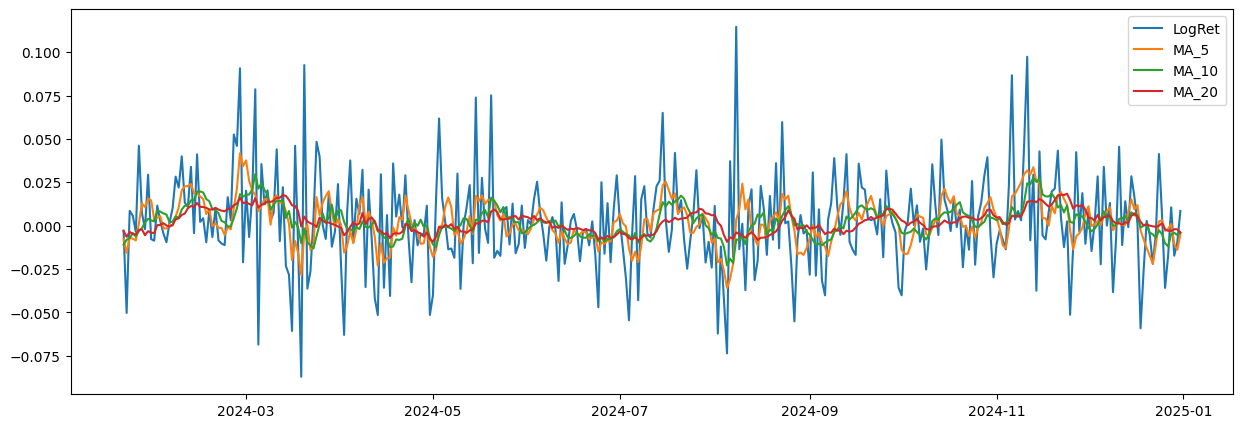

In [11]:

# Draw Line plot of Prices and Moving Averages 
plt.figure(figsize=(15, 5))
# plt.plot(df['Close'], label='Close')
plt.plot(df['LogRet'], label='LogRet')
plt.plot(df['MA_5'], label='MA_5')
plt.plot(df['MA_10'], label='MA_10')
plt.plot(df['MA_20'], label='MA_20')
# plt.plot(df['VWAP'], label='VWAP')
plt.legend()
plt.show()


In [12]:
# Target column is 'Close' left-shifted by 1
# df['target'] = df['Close'].shift(-1)
# df['target'] = df['LogRet'].shift(-1)
df['target'] = df['LogRet'].shift(-5)
df.dropna(inplace=True)

df_train, df_test = df[:-100], df[-100:]

train = torch.tensor(df.values, dtype=torch.float)

target = train[:, -1]
price, ma5, ma10, ma20 = train[:, 1], train[:, 2], train[:, 3], train[:, 4]

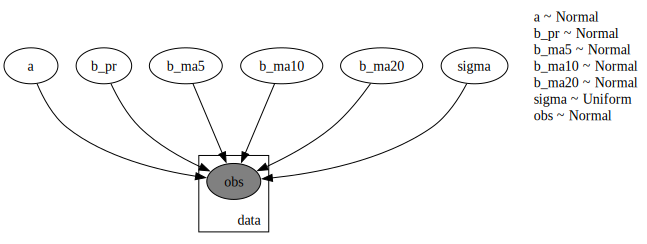

In [13]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def model(price, ma5, ma10, ma20, target=None):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_pr = pyro.sample("b_pr", dist.Normal(0., 1.))
    b_ma5 = pyro.sample("b_ma5", dist.Normal(0., 1.))
    b_ma10 = pyro.sample("b_ma10", dist.Normal(0., 1.))
    b_ma20 = pyro.sample("b_ma20", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))

    mean = a + b_pr * price + b_ma5 * ma5 + b_ma10 * ma10 + b_ma20 * ma20

    with pyro.plate("data", len(price)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=target)

pyro.render_model(model, model_args=(price, ma5, ma10, ma20, target), render_distributions=True)

Elbo loss: 865.2279617190361
Elbo loss: 289.04805409908295
Elbo loss: -400.4548727273941
Elbo loss: -718.2291647791862
Elbo loss: -717.2428112626076
Elbo loss: -718.5739563703537
Elbo loss: -717.1390791535378
Elbo loss: -715.8945188522339
Elbo loss: -715.6830090880394
Elbo loss: -711.788138449192


CPU times: user 2.46 s, sys: 31 ms, total: 2.49 s
Wall time: 2.53 s


Text(0, 0.5, 'ELBO loss')

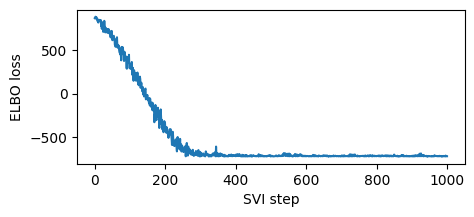

In [14]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(price, ma5, ma10, ma20, target) 
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [15]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.a 0.0040684817
AutoNormal.scales.a 0.0016065678
AutoNormal.locs.b_pr 0.0647998
AutoNormal.scales.b_pr 0.05495006
AutoNormal.locs.b_ma5 -0.18835449
AutoNormal.scales.b_ma5 0.13776624
AutoNormal.locs.b_ma10 0.5534499
AutoNormal.scales.b_ma10 0.18843788
AutoNormal.locs.b_ma20 -0.3773779
AutoNormal.scales.b_ma20 0.22125174
AutoNormal.locs.sigma -5.8902664
AutoNormal.scales.sigma 0.046356175


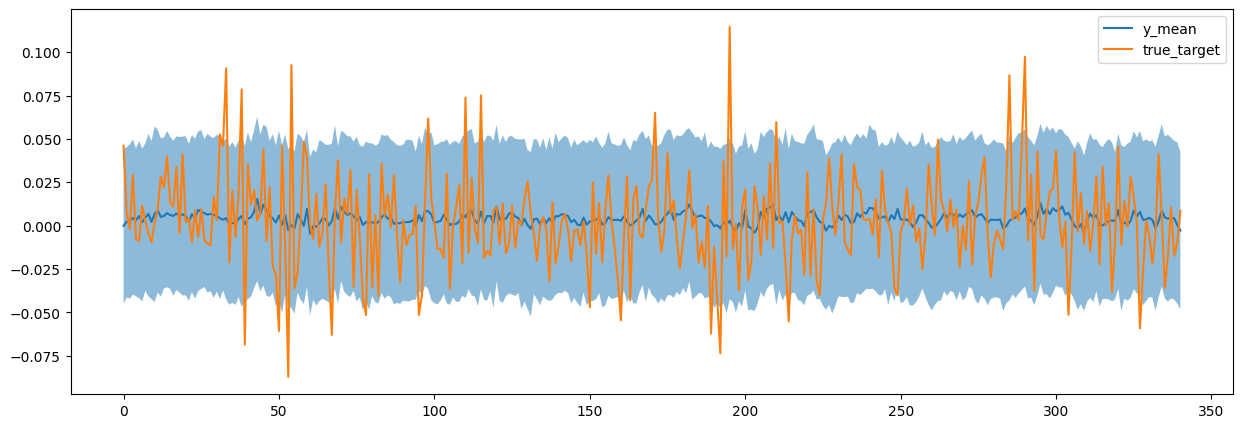

In [16]:
predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=800)
svi_samples = predictive(price, ma5, ma10, ma20, target=None) 
svi_target = svi_samples["obs"]

predictions = pd.DataFrame({
    "price": price,
    "ma5": ma5,
    "ma10": ma10,
    "ma20": ma20,
    "y_mean": svi_target.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_target.kthvalue(int(len(svi_target) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_target.kthvalue(int(len(svi_target) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_target": target,
})

plt.figure(figsize=(15, 5))
plt.plot(predictions["y_mean"], label='y_mean')
plt.fill_between(range(len(predictions)), predictions["y_perc_5"], predictions["y_perc_95"], alpha=0.5)
plt.plot(predictions["true_target"], label='true_target')
plt.legend()

Elbo loss: 773.8355296850204
Elbo loss: 191.78031355142593
Elbo loss: -478.1614819765091
Elbo loss: -708.230871796608
Elbo loss: -715.748820245266
Elbo loss: -715.667515873909
Elbo loss: -716.4388418197632
Elbo loss: -717.4270726442337
Elbo loss: -717.9535878896713
Elbo loss: -716.2972912788391


CPU times: user 2.37 s, sys: 285 ms, total: 2.65 s
Wall time: 2.28 s


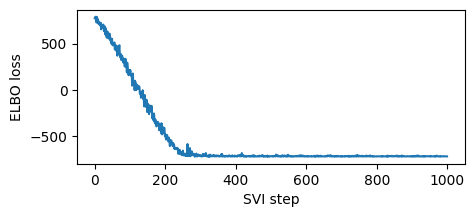

In [17]:
%%time
pyro.clear_param_store()
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
svi = pyro.infer.SVI(model,
                     mvn_guide,
                     pyro.optim.Adam({"lr": 0.02}),
                     pyro.infer.Trace_ELBO())

losses = []
for step in range(1000 if not smoke_test else 2):
    loss = svi.step(price, ma5, ma10, ma20, target) 
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

with pyro.plate("samples", 800, dim=-1):
    mvn_samples = mvn_guide(price, ma5, ma10, ma20)

# Interface note: reuse guide samples for prediction by passing them to Predictive
# via the posterior_samples keyword argument instead of passing the guide as above
assert "obs" not in mvn_samples
mvn_predictive = pyro.infer.Predictive(model, posterior_samples=mvn_samples)
mvn_predictive_samples = mvn_predictive(price, ma5, ma10, ma20, target=None)

mvn_target = mvn_predictive_samples["obs"]

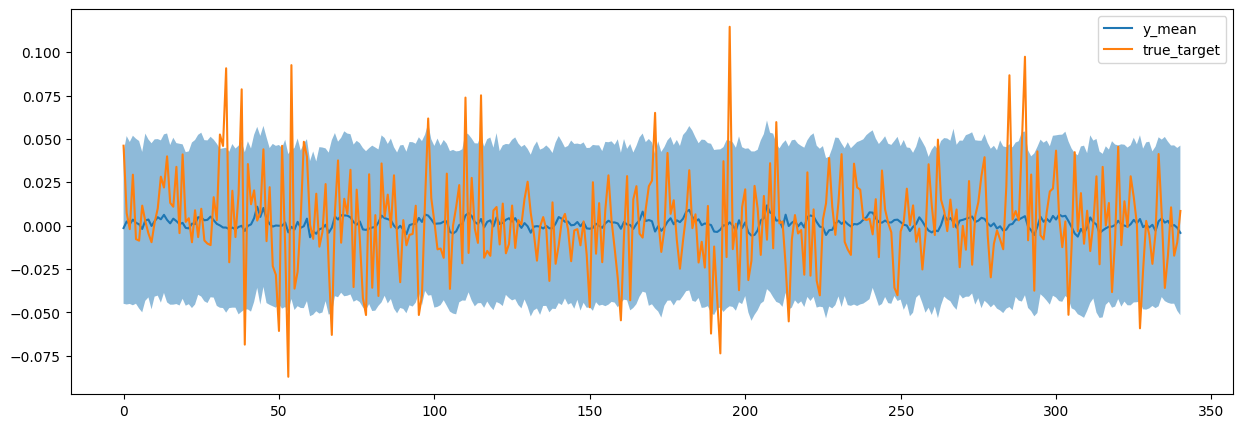

In [18]:
mvn_predictions = pd.DataFrame({
    "price": price,
    "ma5": ma5,
    "ma10": ma10,
    "ma20": ma20,
    "y_mean": mvn_target.mean(0).detach().cpu().numpy(),
    "y_perc_5": mvn_target.kthvalue(int(len(mvn_target) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": mvn_target.kthvalue(int(len(mvn_target) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_target": target,
})

# mvn_predictions = mvn_predictions[-100:]
plt.figure(figsize=(15, 5))
plt.plot(mvn_predictions["y_mean"], label='y_mean')
plt.fill_between(range(len(mvn_predictions)), mvn_predictions["y_perc_5"], mvn_predictions["y_perc_95"], alpha=0.5)
plt.plot(mvn_predictions["true_target"], label='true_target')
plt.legend()

In [19]:
mvn_predictions[-10:]

,price,ma5,ma10,ma20,y_mean,y_perc_5,y_perc_95,true_target
331,0.001045,0.011833,0.006036,0.005040,0.000478,-0.046302,0.042814,-0.022044
332,-0.059179,-0.002814,-0.001187,0.002243,-0.002914,-0.047551,0.045506,-0.004412
333,-0.025826,-0.007809,0.000060,0.000015,0.002529,-0.046473,0.050933,0.041274
334,0.002714,-0.012957,0.001111,0.000673,0.004131,-0.041160,0.049574,0.006295
335,-0.005449,-0.017339,-0.003981,-0.000028,0.001738,-0.043508,0.051122,-0.035922
336,-0.022044,-0.021957,-0.005062,-0.000398,0.002742,-0.044489,0.048396,-0.017169
337,-0.004412,-0.011003,-0.006909,-0.000690,-0.000140,-0.045025,0.046182,0.010554
338,0.041274,0.002417,-0.002696,-0.000047,0.000312,-0.044986,0.046260,-0.017316
339,0.006295,0.003133,-0.004912,0.001381,-0.001221,-0.049115,0.044775,-0.009529
340,-0.035922,-0.002962,-0.010150,-0.002108,-0.004179,-0.051611,0.046138,0.008448
